In [216]:
from collections import defaultdict
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import yfinance as yf
from finta import TA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from tabulate import tabulate
from ta import add_all_ta_features

In [217]:
WINDOW = 34  # number of rows to look ahead to see what the price did
FETCH_INTERVAL = "60m"  # fetch data by interval (including intraday if period < 60 days)
# valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
# (optional, default is '1d')
INTERVAL = '2y'  # use "period" instead of start/end
# valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
# (optional, default is '1mo')
symbol = 'AAPL'  # Symbol of the desired stock
ROWS_TO_PREDICT = 128
# one day 16 rows of data

In [218]:
data = yf.download(  # or pdr.get_data_yahoo(...
        tickers = symbol,


        period = INTERVAL,

        interval = FETCH_INTERVAL,

        # group by ticker (to access via data['SPY'])
        # (optional, default is 'column')
        group_by = 'ticker',

        # adjust all OHLC automatically
        # (optional, default is False)
        # auto_adjust = True,

        # download pre/post regular market hours data
        # (optional, default is False)
        prepost = True,

        # use threads for mass downloading? (True/False/Integer)
        # (optional, default is True)
        threads = True,

        # proxy URL scheme use use when downloading?
        # (optional, default is None)
        proxy = None
    )
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2019-05-10 09:30:00-04:00,NaN,NaN,NaN,NaN,NaN,NaN
2019-05-13 09:00:00-04:00,47.315000,47.345000,46.877500,46.877500,46.877500,0.0
2019-05-13 09:30:00-04:00,46.927502,47.369999,46.424999,46.791050,46.791050,19332487.0
2019-05-13 10:30:00-04:00,46.792500,47.125000,46.625027,46.799999,46.799999,6350368.0
2019-05-13 11:30:00-04:00,46.794998,46.875252,46.540024,46.646252,46.646252,4536523.0
...,...,...,...,...,...,...
2021-05-10 15:30:00-04:00,127.195000,127.500000,126.809998,126.860001,126.860001,11140598.0
2021-05-10 16:00:00-04:00,126.860000,127.988100,117.824670,126.490000,126.490000,0.0
2021-05-10 17:00:00-04:00,126.500000,126.850000,118.090096,126.430000,126.430000,0.0


In [219]:
data.rename(columns={"Close": 'close', "High": 'high', "Low": 'low', 'Volume': 'volume', 'Open': 'open'}, inplace=True)
data.head(10)
data.dropna()

,open,high,low,close,Adj Close,volume
Datetime,,,,,,
2019-05-13 09:00:00-04:00,47.315000,47.345000,46.877500,46.877500,46.877500,0.0
2019-05-13 09:30:00-04:00,46.927502,47.369999,46.424999,46.791050,46.791050,19332487.0
2019-05-13 10:30:00-04:00,46.792500,47.125000,46.625027,46.799999,46.799999,6350368.0
2019-05-13 11:30:00-04:00,46.794998,46.875252,46.540024,46.646252,46.646252,4536523.0
2019-05-13 12:30:00-04:00,46.645000,46.709999,46.270000,46.342499,46.342499,5015671.0
...,...,...,...,...,...,...
2021-05-10 15:30:00-04:00,127.195000,127.500000,126.809998,126.860001,126.860001,11140598.0
2021-05-10 16:00:00-04:00,126.860000,127.988100,117.824670,126.490000,126.490000,0.0
2021-05-10 17:00:00-04:00,126.500000,126.850000,118.090096,126.430000,126.430000,0.0


<AxesSubplot:xlabel='Datetime'>

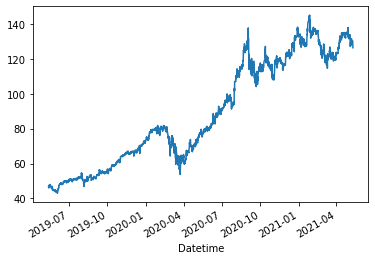

In [220]:
data['close'].plot()

In [221]:
data['close_pct'] = data['close'].pct_change()
data.head()

,open,high,low,close,Adj Close,volume,close_pct
Datetime,,,,,,,
2019-05-10 09:30:00-04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-05-13 09:00:00-04:00,47.315000,47.345000,46.877500,46.877500,46.877500,0.0,NaN
2019-05-13 09:30:00-04:00,46.927502,47.369999,46.424999,46.791050,46.791050,19332487.0,-0.001844
2019-05-13 10:30:00-04:00,46.792500,47.125000,46.625027,46.799999,46.799999,6350368.0,0.000191
2019-05-13 11:30:00-04:00,46.794998,46.875252,46.540024,46.646252,46.646252,4536523.0,-0.003285


In [222]:
data.describe()

,open,high,low,close,Adj Close,volume,close_pct
count,8191.000000,8.191000e+03,8191.000000,8191.000000,8191.000000,8.191000e+03,8190.000000
mean,89.163754,7.889542e+06,88.727648,89.165290,89.165290,3.489824e+06,0.000139
std,30.146873,7.140281e+08,29.939859,30.140895,30.140895,6.665740e+06,0.006026
min,42.970001,4.332500e+01,42.567501,42.972500,42.972500,0.000000e+00,-0.085960
25%,62.207500,6.251374e+01,61.826250,62.192499,62.192499,0.000000e+00,-0.001747
50%,80.250000,8.049500e+01,80.014999,80.262500,80.262500,0.000000e+00,0.000097
75%,119.750000,1.202025e+02,118.960000,119.725000,119.725000,4.241563e+06,0.002047
max,144.900000,6.462250e+10,144.590000,144.910000,144.910000,9.845401e+07,0.078661


In [223]:
def _get_indicator_data(data):
    """
    Function that uses the finta API to calculate technical indicators used as the features
    :return:
    """

    data = add_all_ta_features(
        data, open="open", high="high", low="low", close="close", volume="volume", fillna=True)

    # Instead of using the actual volume value (which changes over time), we normalize it with a moving volume average
    # data['normVol'] = data['volume'] / data['volume'].ewm(5).mean()
    # for i in range(1,50):
    #     data[f'close{i}'] = data['close'].shift(i)
    # Remove columns that won't be used as features
    # del (data['Adj Close'])

    return data


In [224]:
data

,open,high,low,close,Adj Close,volume,close_pct
Datetime,,,,,,,
2019-05-10 09:30:00-04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-05-13 09:00:00-04:00,47.315000,47.345000,46.877500,46.877500,46.877500,0.0,NaN
2019-05-13 09:30:00-04:00,46.927502,47.369999,46.424999,46.791050,46.791050,19332487.0,-0.001844
2019-05-13 10:30:00-04:00,46.792500,47.125000,46.625027,46.799999,46.799999,6350368.0,0.000191
2019-05-13 11:30:00-04:00,46.794998,46.875252,46.540024,46.646252,46.646252,4536523.0,-0.003285
...,...,...,...,...,...,...,...
2021-05-10 15:30:00-04:00,127.195000,127.500000,126.809998,126.860001,126.860001,11140598.0,-0.002595
2021-05-10 16:00:00-04:00,126.860000,127.988100,117.824670,126.490000,126.490000,0.0,-0.002917
2021-05-10 17:00:00-04:00,126.500000,126.850000,118.090096,126.430000,126.430000,0.0,-0.000474


In [225]:
data.columns

Index(['open', 'high', 'low', 'close', 'Adj Close', 'volume', 'close_pct'], dtype='object')

In [226]:
def create_class_column(row, lowest_threshold, higher_threshold):
    if row['close_shift'] - row['close'] > higher_threshold:
        return 1
    if row['close_shift'] - row['close'] < lowest_threshold:
        return -1
    else:
        return 0

In [227]:
data['close_shift'] = data.shift(-WINDOW)['close']
data

,open,high,low,close,Adj Close,volume,close_pct,close_shift
Datetime,,,,,,,,
2019-05-10 09:30:00-04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.852500
2019-05-13 09:00:00-04:00,47.315000,47.345000,46.877500,46.877500,46.877500,0.0,NaN,46.615000
2019-05-13 09:30:00-04:00,46.927502,47.369999,46.424999,46.791050,46.791050,19332487.0,-0.001844,47.287498
2019-05-13 10:30:00-04:00,46.792500,47.125000,46.625027,46.799999,46.799999,6350368.0,0.000191,47.563423
2019-05-13 11:30:00-04:00,46.794998,46.875252,46.540024,46.646252,46.646252,4536523.0,-0.003285,47.584076
...,...,...,...,...,...,...,...,...
2021-05-10 15:30:00-04:00,127.195000,127.500000,126.809998,126.860001,126.860001,11140598.0,-0.002595,NaN
2021-05-10 16:00:00-04:00,126.860000,127.988100,117.824670,126.490000,126.490000,0.0,-0.002917,NaN
2021-05-10 17:00:00-04:00,126.500000,126.850000,118.090096,126.430000,126.430000,0.0,-0.000474,NaN


In [228]:
higher_threshold = 1.5
lowest_threshold = -1.5
last_values_higher = []
last_values_lower = []
data['class_column'] = data.apply((lambda x: create_class_column(x, lowest_threshold, higher_threshold)), axis=1)
while True:
    print(data['class_column'].value_counts())
    class_counts = data['class_column'].value_counts()
    if abs(class_counts[0] - class_counts[1]) < 15 and abs(class_counts[0] - class_counts[-1]) < 15:
        break

    if len(last_values_higher) == 3:
        last_values_higher.pop(0)
    if len(last_values_lower) == 3:
        last_values_lower.pop(0)

    last_values_higher.append(higher_threshold)
    last_values_lower.append(lowest_threshold)
    if class_counts[0] > class_counts[1]:
        higher_threshold -= 0.01
    if class_counts[0] > class_counts[-1]:
        lowest_threshold += 0.01
    if class_counts[0] < class_counts[1]:
        higher_threshold += 0.01
    if class_counts[0] < class_counts[-1]:
        lowest_threshold -= 0.01

    if higher_threshold in last_values_higher and lowest_threshold in last_values_lower:
        break
    print(higher_threshold, lowest_threshold)
    data['class_column'] = data.apply((lambda x: create_class_column(x, lowest_threshold, higher_threshold)), axis=1)

data

 0    4403
 1    2241
-1    1548
Name: class_column, dtype: int64
1.49 -1.49
 0    4376
 1    2256
-1    1560
Name: class_column, dtype: int64
1.48 -1.48
 0    4355
 1    2269
-1    1568
Name: class_column, dtype: int64
1.47 -1.47
 0    4328
 1    2291
-1    1573
Name: class_column, dtype: int64
1.46 -1.46
 0    4310
 1    2300
-1    1582
Name: class_column, dtype: int64
1.45 -1.45
 0    4287
 1    2312
-1    1593
Name: class_column, dtype: int64
1.44 -1.44
 0    4268
 1    2322
-1    1602
Name: class_column, dtype: int64
1.43 -1.43
 0    4237
 1    2341
-1    1614
Name: class_column, dtype: int64
1.42 -1.42
 0    4224
 1    2350
-1    1618
Name: class_column, dtype: int64
1.41 -1.41
 0    4210
 1    2359
-1    1623
Name: class_column, dtype: int64
1.4 -1.4
 0    4187
 1    2379
-1    1626
Name: class_column, dtype: int64
1.39 -1.39
 0    4171
 1    2390
-1    1631
Name: class_column, dtype: int64
1.38 -1.38
 0    4150
 1    2405
-1    1637
Name: class_column, dtype: int64
1.3699999999

,open,high,low,close,Adj Close,volume,close_pct,close_shift,class_column
Datetime,,,,,,,,,
2019-05-10 09:30:00-04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.852500,0
2019-05-13 09:00:00-04:00,47.315000,47.345000,46.877500,46.877500,46.877500,0.0,NaN,46.615000,0
2019-05-13 09:30:00-04:00,46.927502,47.369999,46.424999,46.791050,46.791050,19332487.0,-0.001844,47.287498,0
2019-05-13 10:30:00-04:00,46.792500,47.125000,46.625027,46.799999,46.799999,6350368.0,0.000191,47.563423,0
2019-05-13 11:30:00-04:00,46.794998,46.875252,46.540024,46.646252,46.646252,4536523.0,-0.003285,47.584076,0
...,...,...,...,...,...,...,...,...,...
2021-05-10 15:30:00-04:00,127.195000,127.500000,126.809998,126.860001,126.860001,11140598.0,-0.002595,NaN,0
2021-05-10 16:00:00-04:00,126.860000,127.988100,117.824670,126.490000,126.490000,0.0,-0.002917,NaN,0
2021-05-10 17:00:00-04:00,126.500000,126.850000,118.090096,126.430000,126.430000,0.0,-0.000474,NaN,0


In [229]:
# Class divide
data['class_column'].value_counts()

 1    2742
-1    2738
 0    2712
Name: class_column, dtype: int64

In [230]:
data = _get_indicator_data(data)
data

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\ta\trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\ta\trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


,open,high,low,close,Adj Close,volume,close_pct,close_shift,class_column,volume_adi,...,momentum_wr,momentum_ao,momentum_kama,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,others_dr,others_dlr,others_cr
Datetime,,,,,,,,,,,,,,,,,,,,,
2019-05-10 09:30:00-04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.852500,0,0.000000e+00,...,-50.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.0
2019-05-13 09:00:00-04:00,47.315000,47.345000,46.877500,46.877500,46.877500,0.0,NaN,46.615000,0,0.000000e+00,...,-100.000000,0.000000,4.687750e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.0
2019-05-13 09:30:00-04:00,46.927502,47.369999,46.424999,46.791050,46.791050,19332487.0,-0.001844,47.287498,0,-4.355401e+06,...,-61.264462,0.000000,-2.780269e+04,0.000000,107.692308,107.692308,0.000000,-0.184417,-0.184587,-1.0
2019-05-13 10:30:00-04:00,46.792500,47.125000,46.625027,46.799999,46.799999,6350368.0,0.000191,47.563423,0,-6.260972e+06,...,-60.317448,0.000000,7.173760e+09,0.000000,94.484442,105.050735,-10.566293,0.019126,0.019124,-1.0
2019-05-13 11:30:00-04:00,46.794998,46.875252,46.540024,46.646252,46.646252,4536523.0,-0.003285,47.584076,0,-7.922405e+06,...,-76.587036,0.000000,-2.720108e+14,0.000000,82.764981,100.593584,-17.828603,-0.328520,-0.329061,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-10 15:30:00-04:00,127.195000,127.500000,126.809998,126.860001,126.860001,11140598.0,-0.002595,NaN,0,1.167455e+09,...,-98.641222,-1.837292,9.249230e+30,-2.392859,28.297455,11.574367,16.723087,-0.259456,-0.259793,-1.0
2021-05-10 16:00:00-04:00,126.860000,127.988100,117.824670,126.490000,126.490000,0.0,-0.002917,NaN,0,1.167455e+09,...,-30.484552,-2.738953,9.249230e+30,-2.550077,17.244135,12.708321,4.535815,-0.291661,-0.292087,-1.0
2021-05-10 17:00:00-04:00,126.500000,126.850000,118.090096,126.430000,126.430000,0.0,-0.000474,NaN,0,1.167455e+09,...,-30.519978,-3.791732,9.249230e+30,-2.783545,7.143102,11.595277,-4.452175,-0.047435,-0.047446,-1.0


In [231]:
filename_to_export = f'../data/preprocess_new/{symbol}_{INTERVAL}_{WINDOW}_{ datetime.now().strftime("%d_%m_%Y %H_%M_%S")}_full.csv'
data.to_csv(filename_to_export, index=True)
print(filename_to_export)

../data/preprocess_new/AAPL_2y_34_11_05_2021 09_07_15_full.csv
